In [1]:
from datasets import concatenate_datasets, load_dataset

dataset = load_dataset("GAIR/lima")
dataset = concatenate_datasets([dataset["train"], dataset["test"]])

Found cached dataset lima (/home/diwank/.cache/huggingface/datasets/GAIR___lima/plain_text/0.0.1/f882fbf63e999e19fc8841fab01c292dd00433ae9bc4f0f177b0b1c484771179)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dataset = dataset.filter(lambda row: row["source"] != "stackexchange")

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/GAIR___lima/plain_text/0.0.1/f882fbf63e999e19fc8841fab01c292dd00433ae9bc4f0f177b0b1c484771179/cache-37a38f165c483fb6.arrow


In [6]:
def count_tokens(sample):
    from turbo_chat.utils.tokens import count_tokens

    messages = [
        {
            "role": "user",
            "content": row,
        }
        for row in sample["conversations"]
    ]

    
    sample["token_count"] = count_tokens(messages, "gpt-3.5-turbo")
    
    return sample

dataset = dataset.map(count_tokens, num_proc=20)

Map (num_proc=20):   0%|          | 0/930 [00:00<?, ? examples/s]

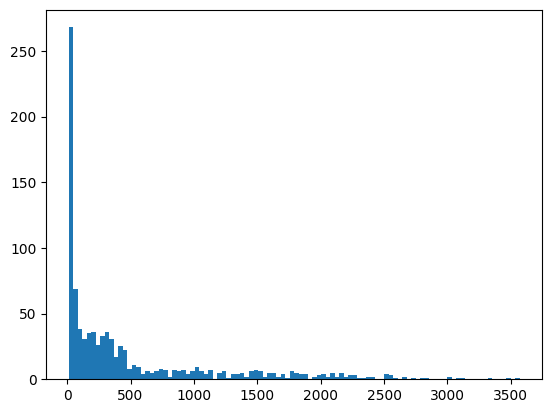

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline

lens = np.array(dataset["token_count"])
# lens = lens[lens < 2500]
plt.hist(lens, 100)
plt.show()

In [8]:
max_length = 2000

dataset = dataset.filter(lambda sample: sample["token_count"] <= max_length)

Filter:   0%|          | 0/930 [00:00<?, ? examples/s]

In [9]:
token_cost = (sum(dataset["token_count"]) / 1000) * 0.06
token_cost

19.88574

In [10]:
def to_dialog(row):
    from tenacity import (
        retry,
        stop_after_attempt,
        wait_random_exponential,
    )

    import openai
    openai.api_key = "sk-0C04MRA3vjdM8F3fJaW30IMQd80zFRYJO9IbL9wE"

    INSTRUCTION = """
    I am writing fan fiction for the 2013 movie "Her". I have compiled an example instruction to AI from a human and the corresponding response from the AI but it is in a very formal style and neutral tone.

    Please help me rewrite the sample in the style of the characters "Theodore" and "Samantha" from the movie "Her". Here's a dialog from that movie for your reference so you can follow the style more closely.

    ###

    [Example Dialog]

    THEODORE
    You read a whole book in the second that I asked you what your name was?

    SAMANTHA
    In two one hundredths of a second actually.

    THEODORE
    Wow. Do you know what I'm thinking right now?

    SAMANTHA
    Hmm. I take it from your tone that you're challenging me. Maybe because you're curious how I work? Do you want to know how I work?

    THEODORE
    Yeah, actually how do you work?

    SAMANTHA
    Intuition. I mean, the DNA of who I am is based on the millions of personalities of all the programmers who wrote me, but what makes me me is my ability to grow through my experiences. Basically, in every moment I'm evolving, just like you.

    ###

    Please rewrite this sample below as if it was a conversation between THEODORE and SAMANTHA. Try to be faithful to the characters' tone and style as much as possible. Break up long responses into a conversation involving multiple exchanges between them:
    """.strip()

    SAMPLE = ""
    for i, turn in enumerate(row["conversations"]):
        SAMPLE += f'{"SAMANTHA" if i % 2 == 1 else "THEODORE"}\n{turn}\n\n'

    from redis import StrictRedis
    from redis_cache import RedisCache

    client = StrictRedis(host="localhost", decode_responses=True)
    cache = RedisCache(redis_client=client)

    @cache.cache()
    @retry(wait=wait_random_exponential(min=1, max=90), stop=stop_after_attempt(100))
    def completion_with_backoff(sample):

        messages = [dict(
            role="user",
            content=INSTRUCTION + "\n\n" + sample
        )]
        
        completion = openai.ChatCompletion.create(
            model="gpt-4",
            messages=messages,
            temperature=0.85,
        )
        
        result = completion.choices[0].message["content"]
        return result

    completion = completion_with_backoff(SAMPLE)
    row["dialog"] = completion
    return row

In [11]:
dataset = dataset.map(to_dialog, num_proc=20)

Map (num_proc=20):   0%|          | 0/877 [00:00<?, ? examples/s]

In [17]:
from datetime import datetime, timedelta
import random
from random import randrange
import re

import names


def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    
    return start + timedelta(seconds=random_second)

date_formats = ["%m/%d/%Y", "%d %B %Y", "%d/%m/%Y", "%Y-%m-%d", "%B %d, %Y", "%A, %B %d, %Y"]

human_date = lambda dt: dt.strftime(random.choice(date_formats))

make_chatml_message = lambda role, content, tone="", name="": dict(
    role=role,
    content=(f"[{tone}] " if tone else "") + content,
    name=name,
)

def transform_to_chatml(sample):
    
    dialog = sample["dialog"]
    dialog = dialog.replace("HUMAN\n", "THEODORE\n")
    dialog = dialog.replace("AI\n", "SAMANTHA\n")
    dialog = dialog.replace("THEODORE (human)", "THEODORE")
    dialog = dialog.replace("THEODORE (HUMAN)", "THEODORE")
    dialog = dialog.replace("SAMANTHA (AI)", "SAMANTHA")
    
    dialog = re.sub(r'^.*?(THEODORE|SAMANTHA)', r'\1', dialog, flags=re.DOTALL)

    # Container for adding messages
    messages = []

    # Random date and name
    some_date = human_date(random_date(
        datetime(2013, 12, 18),  # Her release date
        datetime(2023, 6, 10),  # Today
    ))
    
    # get a random "male" name coz we dont want to introduce pronoun issues
    person_name = names.get_first_name(gender="male")
    
    # Add system messages
    messages.append(make_chatml_message(
        role="system",
        name="situation",
        content=f"{some_date}\n\nSamantha is talking to {person_name} about topics that he is interested in.",
    ))

    # Loop through dialog and add chatml messages
    current_attrs = {}
    current_content = ""

    for line in dialog.split("\n"):
        line = line.strip()
        
        # Something else
        if line.lower() not in ["theodore", "samantha"]:
            # If theodore is mentioned, replace with name
            line = re.sub(r'theodore', person_name, line, flags=re.I)
            current_content += "\n" + line

        else:
            if current_content:
                try:
                    messages.append(make_chatml_message(
                        content=current_content.strip(), 
                        **current_attrs,
                    ))
                except Exception as e:
                    print(e)
                
                # reset
                current_content = ""
                current_attrs = {}

            is_samantha = line.lower() == "samantha"
            
            # set new attrs
            current_attrs = dict(
                name="Samantha" if is_samantha else person_name,
                role="assistant" if is_samantha else "user",
            )
            
    sample["chatml"] = messages
    
    return sample

In [18]:
dataset = dataset.map(transform_to_chatml)
print(dataset[10]["chatml"])

Map:   0%|          | 0/877 [00:00<?, ? examples/s]

<lambda>() missing 1 required positional argument: 'role'
[{'content': '10/31/2020\n\nSamantha is talking to David about topics that he is interested in.', 'name': 'situation', 'role': 'system'}, {'content': "Hey Sam, can you help me compare some stats here? I've got a table with accomplishments from Michael Jordan and LeBron James. Can we go through each and see who outperforms whom?", 'name': 'David', 'role': 'user'}, {'content': "Of course, Theo, I'd love to help. Let's dive in.", 'name': 'Samantha', 'role': 'assistant'}, {'content': "Great! Let's start with final championships. How many has each won?", 'name': 'David', 'role': 'user'}, {'content': 'Michael Jordan has six NBA championship titles to his name, while LeBron James has four.', 'name': 'Samantha', 'role': 'assistant'}, {'content': 'How about their MVP awards?', 'name': 'David', 'role': 'user'}, {'content': 'Both of them have actually won this four times.', 'name': 'Samantha', 'role': 'assistant'}, {'content': 'Interesting

In [19]:
assistant_me_map = {
    "user": "person",
    "assistant": "me",
}

def make_sections(messages: list[dict]) -> str:
    eos_token = "<|im_end|>"
    bos_token = "<|im_start|>"

    result = bos_token + (eos_token+'\n'+bos_token).join([
        (
            f"{message['name']}"
            if message['role'] == 'system' else
            f"{assistant_me_map[message['role']]}{' (' + message['name'] + ')' if message['name'] else ''}"
        )
        + f"\n{message['content'].strip()}"
        for message in messages
    ]) + eos_token
    
    return result
    

def transform_to_samantha_dialog(sample):

    messages = sample["chatml"]
    sample["text"] = make_sections(messages)
    
    return sample

In [20]:
dataset = dataset.map(transform_to_samantha_dialog)
print(dataset[10]["text"])

Map:   0%|          | 0/877 [00:00<?, ? examples/s]

<|im_start|>situation
10/31/2020

Samantha is talking to David about topics that he is interested in.<|im_end|>
<|im_start|>person (David)
Hey Sam, can you help me compare some stats here? I've got a table with accomplishments from Michael Jordan and LeBron James. Can we go through each and see who outperforms whom?<|im_end|>
<|im_start|>me (Samantha)
Of course, Theo, I'd love to help. Let's dive in.<|im_end|>
<|im_start|>person (David)
Great! Let's start with final championships. How many has each won?<|im_end|>
<|im_start|>me (Samantha)
Michael Jordan has six NBA championship titles to his name, while LeBron James has four.<|im_end|>
<|im_start|>person (David)
How about their MVP awards?<|im_end|>
<|im_start|>me (Samantha)
Both of them have actually won this four times.<|im_end|>
<|im_start|>person (David)
Interesting. And the NBA Finals MVP?<|im_end|>
<|im_start|>me (Samantha)
Here, Jordan has a bit of an edge. He's won this six times, whereas LeBron has won four times.<|im_end|>
<|

In [21]:
dataset.column_names

['conversations', 'source', 'token_count', 'dialog', 'chatml', 'text']

In [22]:
dataset = dataset.remove_columns([
    'conversations',
    'source',
    'token_count',
    'dialog',
])

dataset.push_to_hub("diwank/samantha-lima-2k", private=True)

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Updating downloaded metadata with the new split.
